In [129]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cloropleth

%matplotlib inline
%config InlineBackend.figure_format='retina'

SCL_DATA_PATH = Path("../data/external/scl/")

PATH_CENSUS = SCL_DATA_PATH / "census"
PATH_URBAN_AREAS = SCL_DATA_PATH / "urban_areas"
PATH_R13 = SCL_DATA_PATH / "R13"


In [130]:
census = (pd.read_csv(PATH_CENSUS / 'Censo2017_Manzanas.csv', sep=';')
          .merge(pd.read_csv(PATH_CENSUS / 'Censo2017_Identificación_Geográfica' / 'Microdato_Censo2017-Urbano.csv', sep=';'))
          .pipe(lambda x: x[x.REGION == 13])
          .drop('ZONA', axis=1)
          .drop_duplicates()
         )
count_columns = ['HOMBRES', 'MUJERES','EDAD_0A5', 'EDAD_6A14', 'EDAD_15A64', 'EDAD_65YMAS', 'INMIGRANTES']
for col in count_columns:
    census[col] = census[col].replace('*', 0).astype(int)
dc_values = census.groupby(['REGION', 'PROVINCIA', 'COMUNA', 'DC'])[count_columns].sum().reset_index().rename(columns={'DC': 'COD_DISTRI'})

dc_values

,REGION,PROVINCIA,COMUNA,COD_DISTRI,HOMBRES,MUJERES,EDAD_0A5,EDAD_6A14,EDAD_15A64,EDAD_65YMAS,INMIGRANTES
0,13,131,13101,1,5151,5076,320,264,8482,932,1919
1,13,131,13101,2,10755,10144,1111,959,17455,1232,7824
2,13,131,13101,3,12092,11490,1230,1043,19663,1069,7824
3,13,131,13101,4,6539,7026,667,858,10493,1473,2583
4,13,131,13101,5,4872,5042,675,821,7503,858,3450
...,...,...,...,...,...,...,...,...,...,...,...
406,13,136,13604,3,9742,9924,1540,2193,13318,2205,508
407,13,136,13604,4,14139,14479,2272,3598,19935,2003,593
408,13,136,13605,1,11671,12429,1736,3164,16419,2203,299
409,13,136,13605,2,15387,16198,2731,3976,21746,2300,520


/home/flac/miniconda3/envs/urbana/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

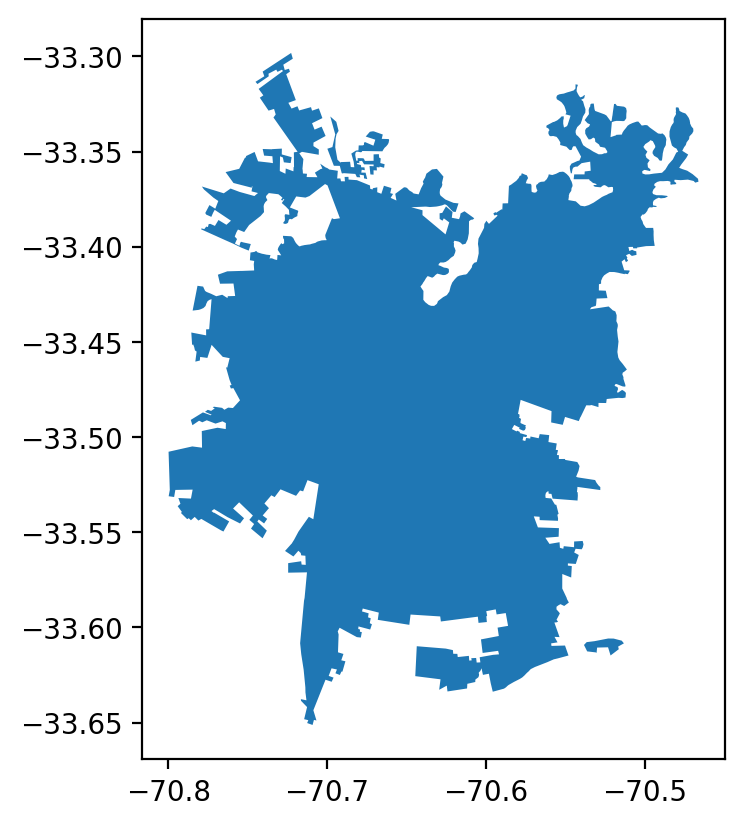

In [131]:
urban_stgo = (gpd.read_file(PATH_URBAN_AREAS, crs={'init': 'epsg:5361'})
               .to_crs({'init': 'epsg:4326'})
               .pipe(lambda x: x[x.NOMBRE == 'Santiago'].copy()))
    
urban_stgo.plot()

451


<AxesSubplot: >

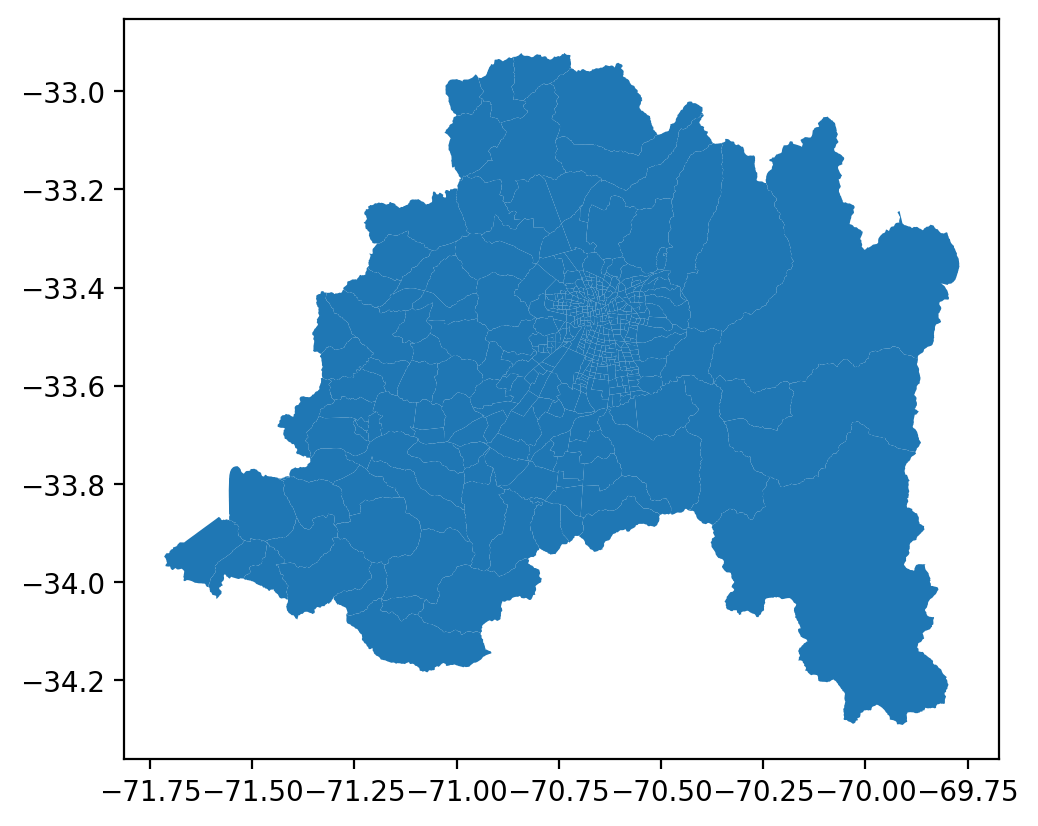

In [132]:
orig = (gpd.read_file(PATH_R13).assign(REGION=lambda x: x.REGION.astype(int))
         .assign(PROVINCIA=lambda x: x.PROVINCIA.astype(int))
         .assign(COMUNA=lambda x: x.COMUNA.astype(int))
         .assign(COD_DISTRI=lambda x: x.COD_DISTRI.astype(int)))
print(len(orig))


orig.plot()

In [133]:
urban_districts = (orig
         .pipe(lambda x: x.assign(geometry=x.geometry.map(lambda y: urban_stgo.loc[385].geometry.intersection(y))))
         .pipe(lambda x: x[(x.area > 0)].copy()))
len(urban_districts)

/tmp/ipykernel_12575/2341987484.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  .pipe(lambda x: x[(x.area > 0)].copy()))


342

<AxesSubplot: >

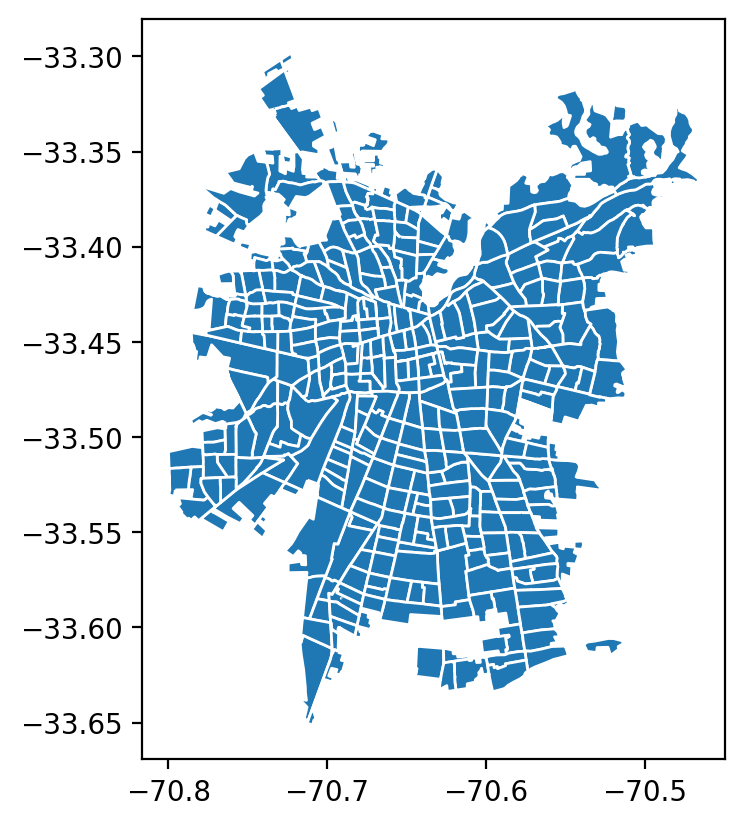

In [134]:
urban_districts.plot(edgecolor='white')

In [135]:
urban_districts.to_file(SCL_DATA_PATH / 'urban_districts' / 'stgo_urban_districts.shp', driver='ESRI Shapefile')

/home/flac/miniconda3/envs/urbana/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot: >

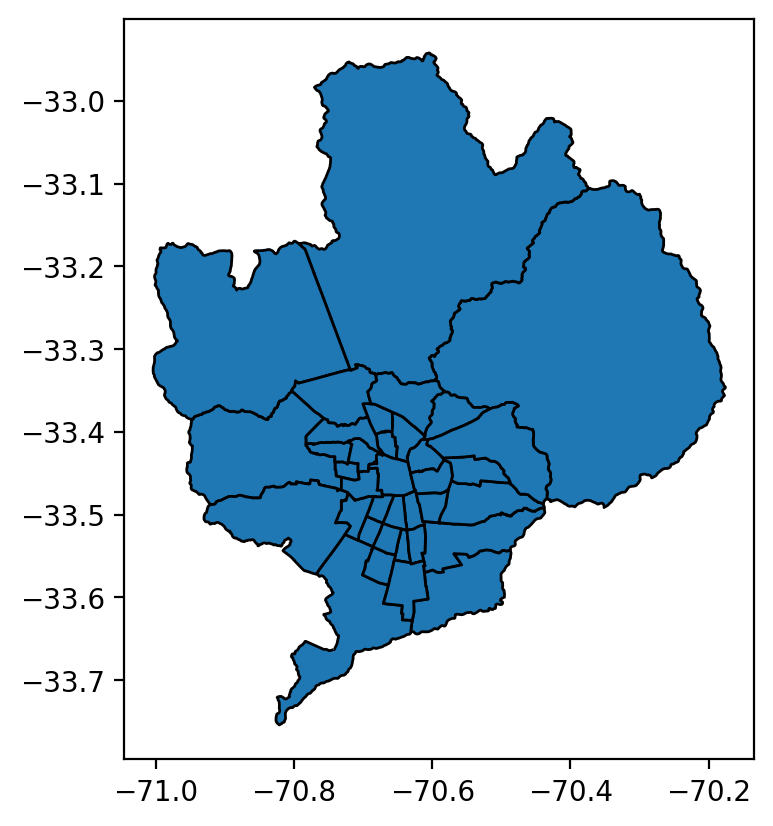

In [136]:
municipalities = gpd.read_file(SCL_DATA_PATH / "shapefile_comunas")
municipalities = municipalities.to_crs(urban_stgo.crs)


urban_municipalities = gpd.sjoin(municipalities, urban_stgo, how='inner', op='intersects')
urban_municipalities.plot(edgecolor="black")

In [137]:
urban_data = urban_districts.merge(dc_values, how='inner')
urban_data.sample(5)

,REGION,PROVINCIA,COMUNA,COD_DISTRI,DESC_REGIO,DESC_PROVI,DESC_COMUN,DESC_DISTR,geometry,HOMBRES,MUJERES,EDAD_0A5,EDAD_6A14,EDAD_15A64,EDAD_65YMAS,INMIGRANTES
170,13,131,13127,4,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,RECOLETA,LO ARÁNGUIZ,"POLYGON ((-70.65631 -33.38690, -70.65624 -33.3...",7764,8333,1111,1648,10844,2274,1060
240,13,131,13126,2,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,QUINTA NORMAL,CARRASCAL,"POLYGON ((-70.70616 -33.40790, -70.70592 -33.4...",7569,8153,921,1431,10867,2140,998
115,13,131,13110,10,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LA FLORIDA,SANTA AMALIA,"POLYGON ((-70.57724 -33.53969, -70.57664 -33.5...",8490,9569,1035,1526,12228,2790,711
92,13,131,13109,1,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LA CISTERNA,LA CISTERNA,"POLYGON ((-70.66421 -33.53727, -70.66421 -33.5...",7853,8709,1091,1738,11202,2350,656
5,13,131,13114,1,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,ESCUELA MILITAR,"POLYGON ((-70.56793 -33.39800, -70.56716 -33.3...",13042,13850,1852,1805,19724,3275,4427


In [138]:
urban_data['POPULATION'] = urban_data['HOMBRES'] + urban_data['MUJERES']
urban_data.POPULATION.describe()

count      342.000000
mean     17858.394737
std      12753.122789
min        440.000000
25%      11400.750000
50%      14643.500000
75%      20322.500000
max      98090.000000
Name: POPULATION, dtype: float64

In [139]:
urban_data['RATIO'] = ((urban_data['MUJERES'] - urban_data['HOMBRES']) / urban_data['POPULATION'] * 100)
urban_data.RATIO.describe()

count    342.000000
mean       2.742708
std        5.605334
min      -83.073011
25%        1.301957
50%        2.728653
75%        4.469270
max       11.570881
Name: RATIO, dtype: float64

In [140]:
urban_data['IMMIGRANT_%'] = urban_data['INMIGRANTES'] / urban_data['POPULATION'] * 100
urban_data['IMMIGRANT_%'].describe()

count    342.000000
mean       8.224377
std        9.434377
min        0.000000
25%        2.399305
50%        4.916366
75%        8.813560
max       53.320236
Name: IMMIGRANT_%, dtype: float64

In [141]:
urban_data['RETIRED_%'] = urban_data['EDAD_65YMAS'] / urban_data['POPULATION'] * 100
urban_data['RETIRED_%'].describe()

count    342.000000
mean      11.914783
std        4.043622
min        0.000000
25%        8.924081
50%       12.508958
75%       14.787759
max       20.260310
Name: RETIRED_%, dtype: float64

<AxesSubplot: >

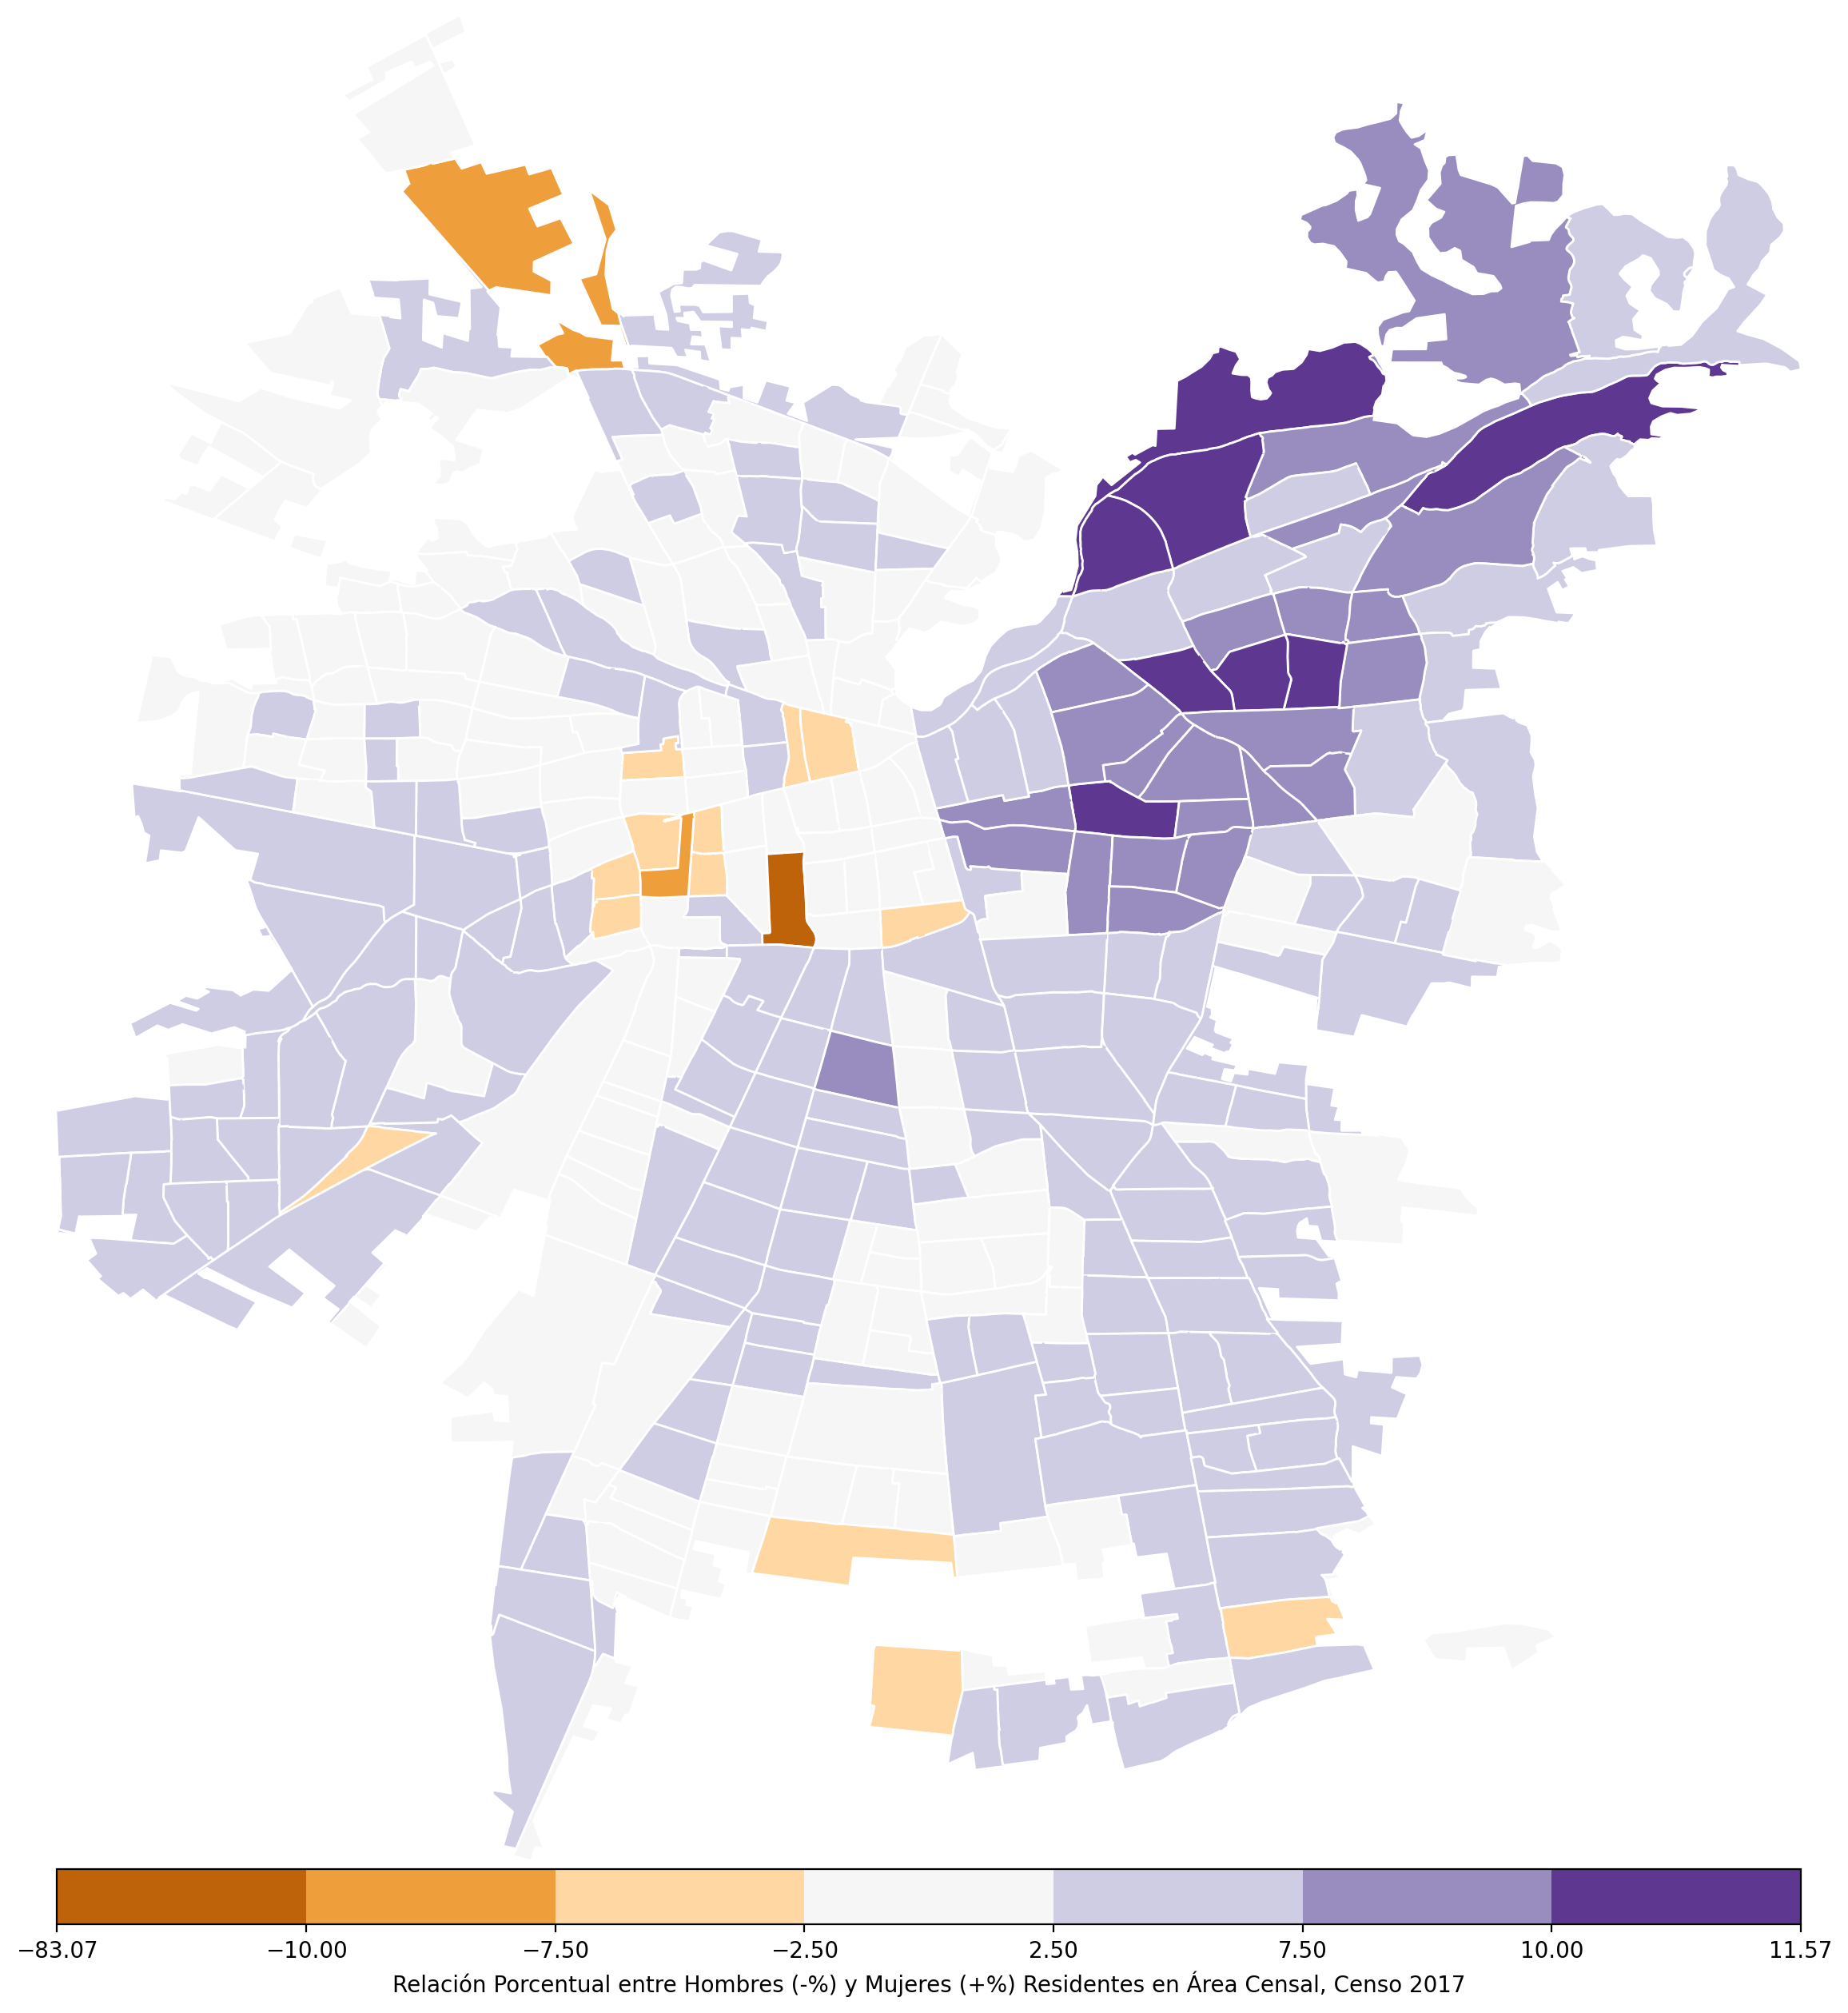

In [142]:
choropleth(urban_data, column='RATIO', alpha=1.0, cbar_orientation='horizontal', palette='PuOr', n_colors=7,
                     scheme='user_defined', user_bins=[urban_data.RATIO.min(), -10, -7.5, -2.5, 2.5, 7.5, 10, urban_data.RATIO.max()],
                     cbar_label='Relación Porcentual entre Hombres (-%) y Mujeres (+%) Residentes en Área Censal, Censo 2017')

<AxesSubplot: >

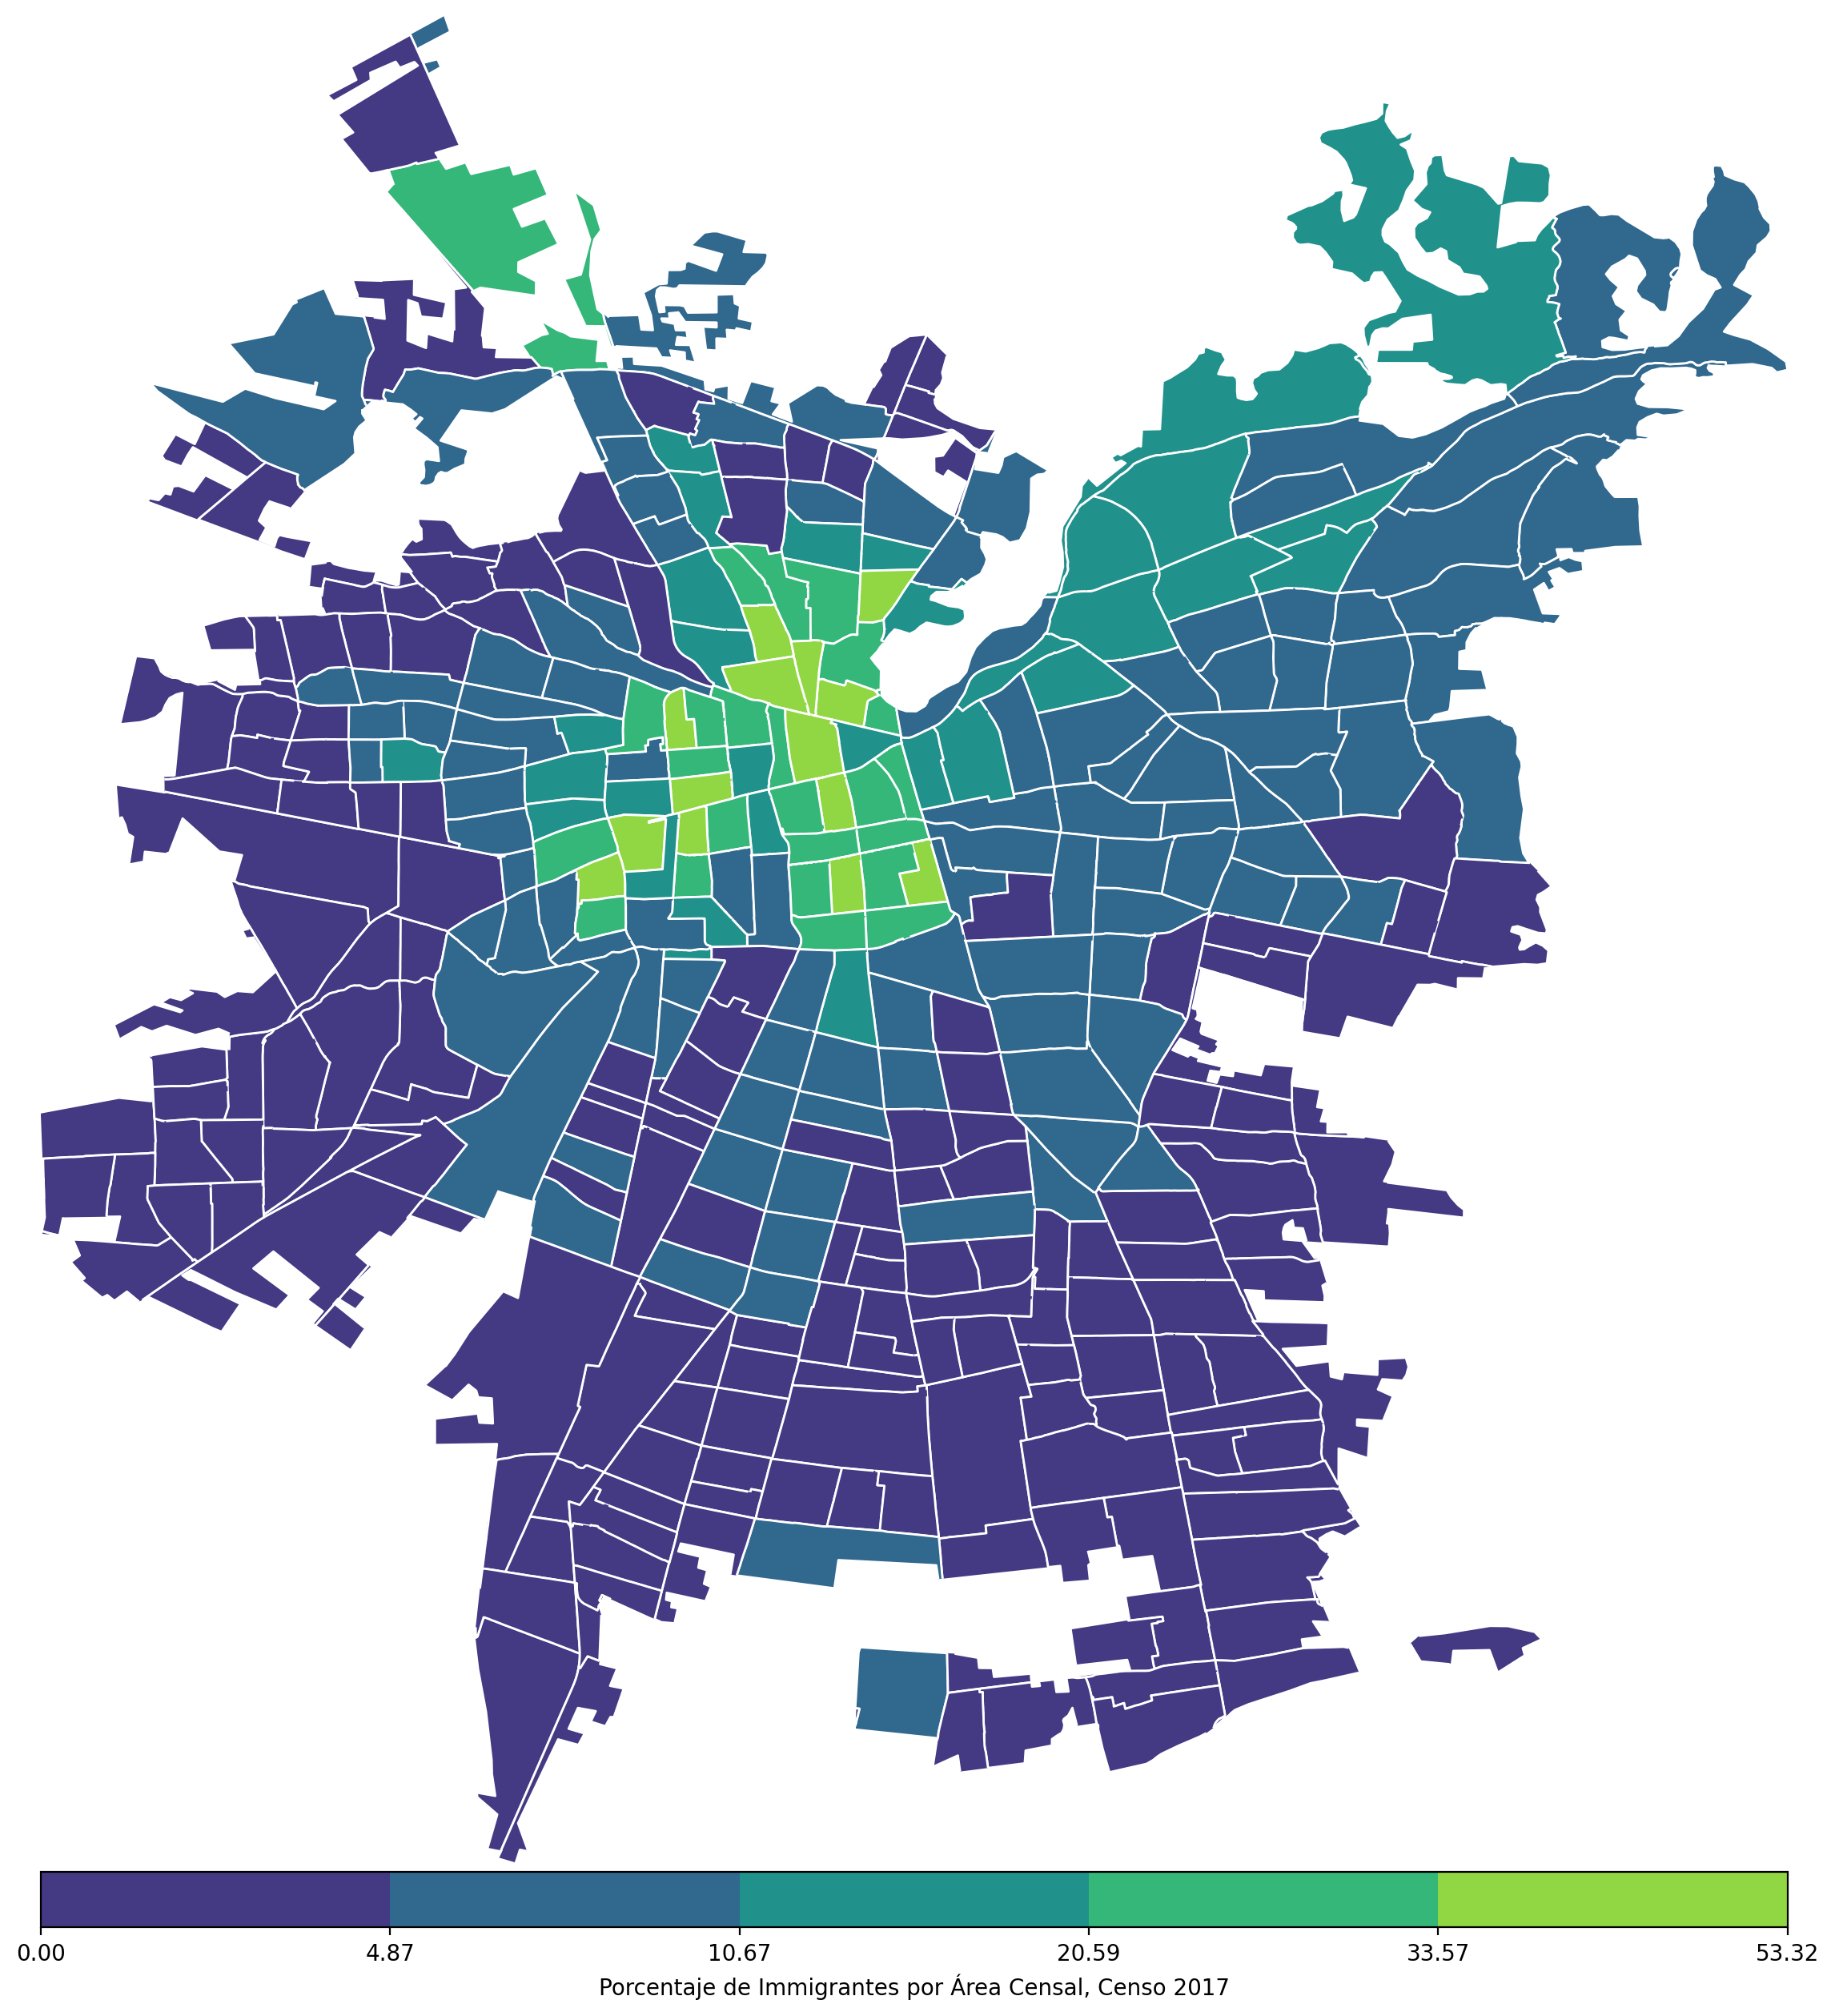

In [143]:
choropleth(urban_data, column='IMMIGRANT_%', alpha=1.0, cbar_orientation='horizontal', cbar_label='Porcentaje de Immigrantes por Área Censal, Censo 2017')